In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL


import copy

import tensorflow_datasets as tfds
from tensorflow import keras

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터셋 준비하기

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


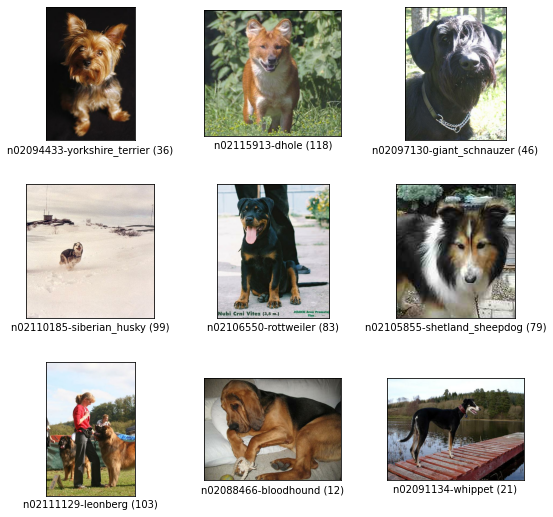

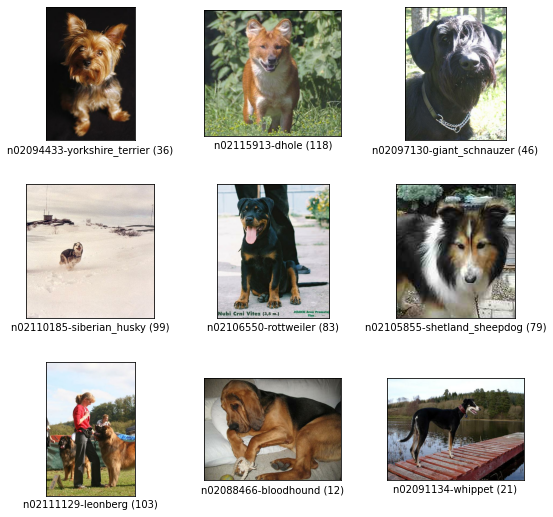

In [5]:
# 이미지클래스와 인덱스를 확인해보기 

tfds.show_examples(ds_train, ds_info)

In [6]:
# 데이터 전처리 함수 구현

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [8]:
# CAM을 위한 모델 만들기

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
# preds = ADD_YOUR_DENSE_LAYER(x)
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 198s 203ms/step - loss: 2.2465 - accuracy: 0.4346 - val_loss: 3.6752 - val_accuracy: 0.1657
Epoch 2/15
750/750 [==============================] - 154s 205ms/step - loss: 0.6418 - accuracy: 0.8292 - val_loss: 1.1843 - val_accuracy: 0.6493
Epoch 3/15
750/750 [==============================] - 154s 205ms/step - loss: 0.1871 - accuracy: 0.9701 - val_loss: 0.9828 - val_accuracy: 0.7104
Epoch 4/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0581 - accuracy: 0.9968 - val_loss: 0.9447 - val_accuracy: 0.7271
Epoch 5/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0279 - accuracy: 0.9992 - val_loss: 0.9596 - val_accuracy: 0.7304
Epoch 6/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0189 - accuracy: 0.9997 - val_loss: 0.9709 - val_accuracy: 0.7317
Epoch 7/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0157 - accuracy: 0.9995 - val_loss: 0.9569 -

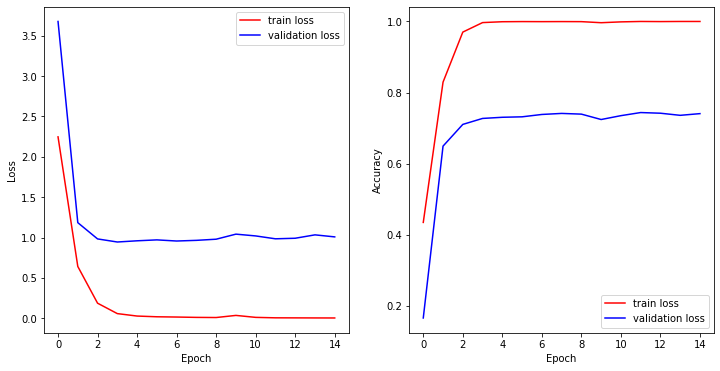

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_cam_model.history['loss'], 'r')
ax1.plot(history_cam_model.history['val_loss'], 'b')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train loss', 'validation loss'], loc='upper right')

ax2.plot(history_cam_model.history['accuracy'], 'r')
ax2.plot(history_cam_model.history['val_accuracy'], 'b')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['train loss', 'validation loss'], loc='lower right')

plt.show()

In [11]:
# 모델 저장하기

import os

cam_model_path = os.getenv('HOME')+'/aiffel/Quest/0_Going_Deeper/cam_model1.h5'

# [[YOUR CODE]]

cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [165]:
# 1. CAM 구현하기

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [166]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    src1 = item['image'].astype(np.uint8)
    src2 = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)    
    merged_image = cv2.addWeighted(src1, alpha, src2, (1.0 - alpha), 0.0)
    return merged_image

In [167]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    #print(sample_data[0])
    return sample_data[0]

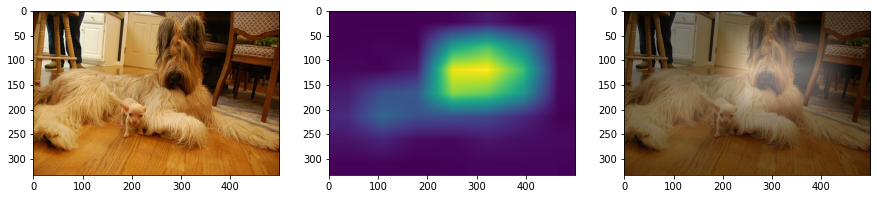

In [168]:
item = get_one(ds_test)

plt.subplots(1,3, figsize=(15,5))

image = item['image']
plt.subplot(1,3,1)
plt.imshow(image)

cam_image = generate_cam(cam_model, item)
plt.subplot(1,3,2)
plt.imshow(cam_image)

merged_image = visualize_cam_on_image(image, cam_image)
plt.subplot(1,3,3)
plt.imshow(merged_image)

plt.show()

In [169]:
# Grad-CAM 구현하기

In [170]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

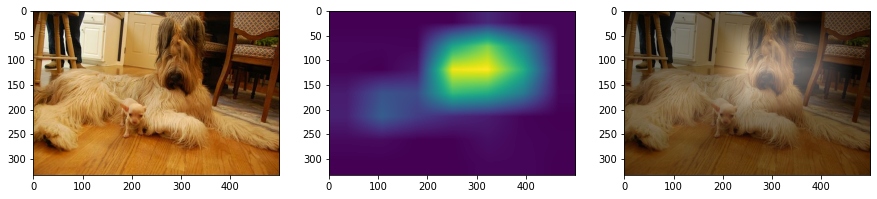

In [171]:
#item = get_one(ds_test)

plt.subplots(1,3, figsize=(15,5))

image = item['image']
plt.subplot(1,3,1)
plt.imshow(image)

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.subplot(1,3,2)
plt.imshow(grad_cam_image)

merged_image = visualize_cam_on_image(image, grad_cam_image)
plt.subplot(1,3,3)
plt.imshow(merged_image)

plt.show()

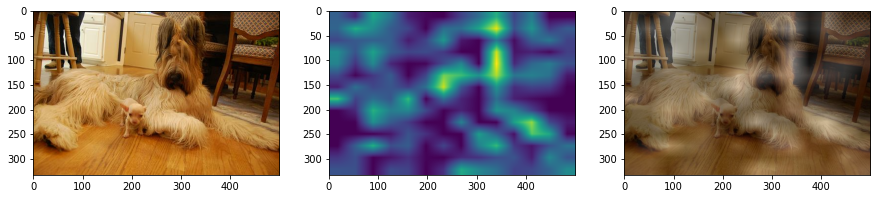

In [172]:
#item = get_one(ds_test)

plt.subplots(1,3, figsize=(15,5))

image = item['image']
plt.subplot(1,3,1)
plt.imshow(image)

grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.subplot(1,3,2)
plt.imshow(grad_cam_image)

merged_image = visualize_cam_on_image(image, grad_cam_image)
plt.subplot(1,3,3)
plt.imshow(merged_image)

plt.show()

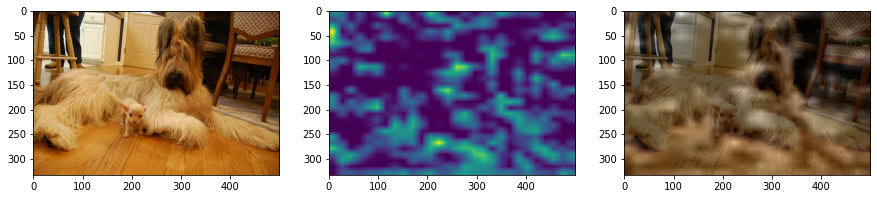

In [173]:
#item = get_one(ds_test)

plt.subplots(1,3, figsize=(15,5))

image = item['image']
plt.subplot(1,3,1)
plt.imshow(image)

grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.subplot(1,3,2)
plt.imshow(grad_cam_image)

merged_image = visualize_cam_on_image(image, grad_cam_image)
plt.subplot(1,3,3)
plt.imshow(merged_image)

plt.show()

In [174]:
# 바운딩 박스 구하기

In [175]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [176]:
# bbox 좌표를 rect로 변환

def minmax_to_rect(bbox, image):
    y_min, x_min, y_max, x_max = bbox
    rect = np.array([
        [int(x_min * image.shape[1]), int(y_min * image.shape[0])],
        [int(x_max * image.shape[1]), int(y_min * image.shape[0])],
        [int(x_max * image.shape[1]), int(y_max * image.shape[0])],
        [int(x_min * image.shape[1]), int(y_max * image.shape[0])]
    ])
    return rect

ori_box = minmax_to_rect(item['objects']['bbox'][0], item['image'])
#ori_box1 = minmax_to_rect(item['objects']['bbox'][1], item['image'])

In [177]:
rect = get_bbox(cam_image)
rect

array([[-17,  23],
       [451, -11],
       [471, 257],
       [  2, 292]])

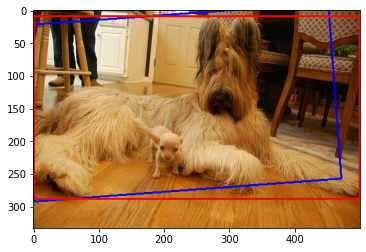

In [178]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image = cv2.drawContours(image, [ori_box], 0, (255,0,0), 2)
#image = cv2.drawContours(image, [ori_box1], 0, (0,255,0), 2)
plt.imshow(image)
plt.show()

In [179]:
# IoU 구하기

In [180]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [181]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.03303303303303303, -0.034, 0.8768768768768769, 0.942]

In [182]:
item['objects']['bbox']

array([[0.02702703, 0.002     , 0.8648649 , 0.998     ]], dtype=float32)

In [183]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [184]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.8423263866906634

In [185]:
def show_cam(item, cam_image, title='CAM'):
    image = item['image']
    
    plt.subplots(1,3, figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title(title)
    plt.imshow(cam_image)
    
    merged_image = visualize_cam_on_image(image, cam_image)
    plt.subplot(1,3,2)
    plt.title(title + ' Merged')
    plt.imshow(merged_image)
    
    rect = get_bbox(cam_image)
    bbox_image = copy.deepcopy(item['image'])
    bbox_image = cv2.drawContours(bbox_image, [rect], 0, (0,0,255), 2)

    cam_bbox = rect_to_minmax(rect, item['image'])    
    label_bbox = item['objects']['bbox'][0]
    iou = get_iou(cam_bbox, label_bbox)
    iou_title = title + ' BBox IoU : %f' % iou

    plt.subplot(1,3,3)
    plt.title(iou_title)
    plt.imshow(bbox_image)

    plt.show()

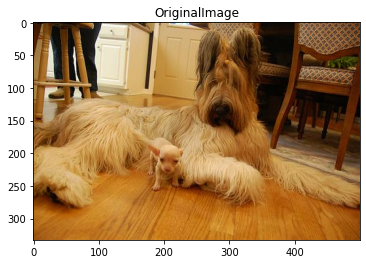

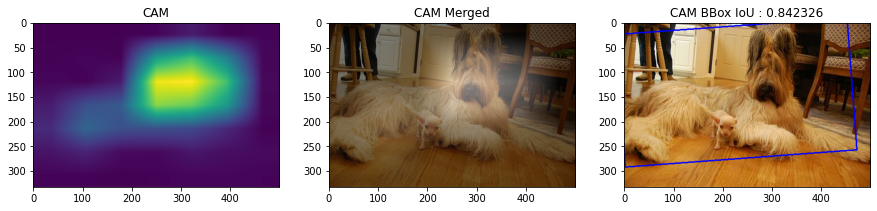

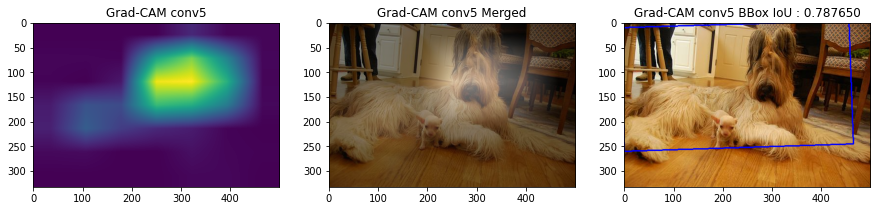

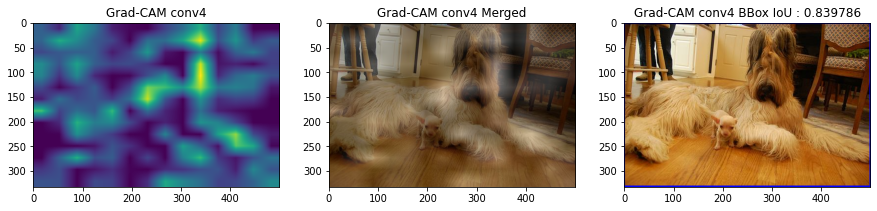

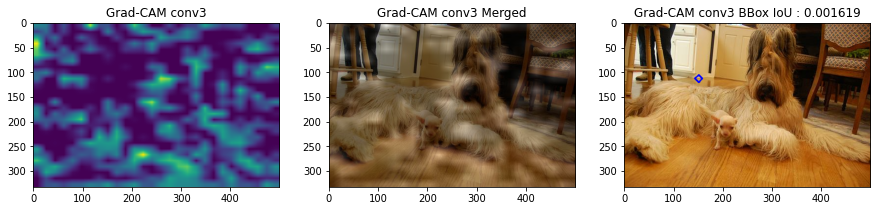

In [186]:
# CAM vs Grad-CAM

#item = get_one(ds_test)

image = item['image']
plt.imshow(image)
plt.title('OriginalImage')
plt.show()

cam_image = generate_cam(cam_model, item)
show_cam(item, cam_image)

grad_conv5_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
show_cam(item, grad_conv5_image, 'Grad-CAM conv5')

grad_conv5_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
show_cam(item, grad_conv5_image, 'Grad-CAM conv4')

grad_conv5_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
show_cam(item, grad_conv5_image, 'Grad-CAM conv3')